### Loading the train and test logits/likelyhoods

In [2]:
import torch
import torch.nn.functional as F

cal_path = 'calibration_logits.pth'
test_path = 'test_logits.pth'

cal_data = torch.load(cal_path, weights_only=False)
test_data = torch.load(test_path, weights_only=False)

cal_logits = cal_data["logits"] 
cal_images = cal_data["images"]  
cal_gt_masks = cal_data["masks"]    
cal_probs = F.softmax(cal_logits, dim=1)

test_logits = test_data["logits"] 
test_images = test_data["images"]  
test_gt_masks = test_data["masks"]    
test_probs = F.softmax(test_logits, dim=1)

### Obtaining Lower Bound

In [3]:
def obtain_lower_bound(probs, alpha=0.1, eps=1e-6):
    
    assert probs.dim() == 4, "Input probabilities must be a 4D tensor."
    
    entropy = -torch.sum(probs * torch.log(probs + eps), dim=1)  # (N, H, W)
    lower_bound = (probs - alpha * entropy.unsqueeze(1)).clamp(0, 1)       # (N, C, H, W)

    return lower_bound

cal_lower_bound = obtain_lower_bound(cal_probs)
test_lower_bound = obtain_lower_bound(test_probs)

### Visualize distribution of likelyhood by class

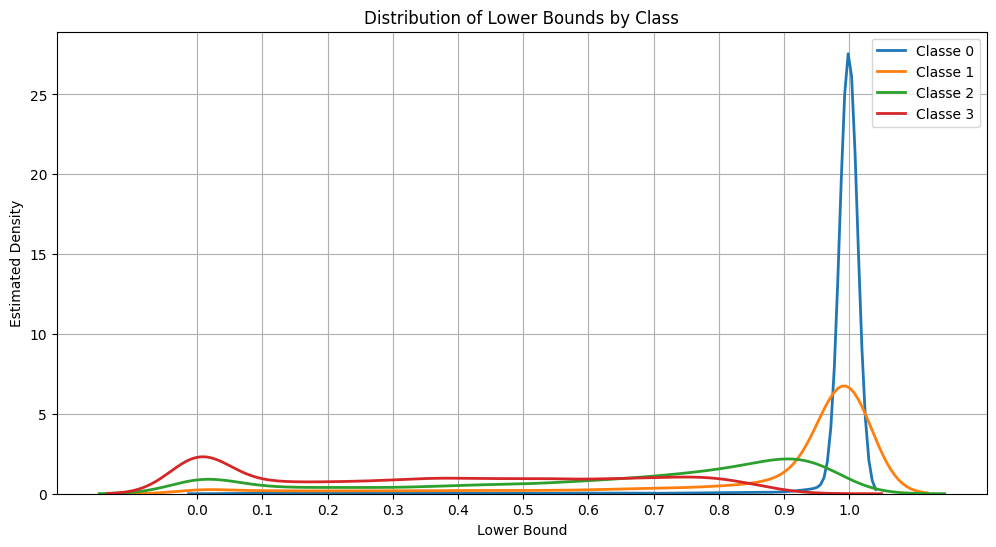

In [5]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_lower_bound_distribution(lower_bound, labels, sample_size=10000):
    
    N, C, H, W = lower_bound.shape

    plt.figure(figsize=(12, 6))

    for c in range(C):
        mask = (labels == c).unsqueeze(1)  # shape: (N, 1, H, W)
        lower_c = lower_bound[:, c, :, :][mask.squeeze(1)]

        if lower_c.numel() > sample_size:
            indices = torch.randperm(lower_c.numel())[:sample_size]
            lower_c = lower_c[indices]

        sns.kdeplot(lower_c.cpu().numpy(), label=f'Classe {c}', linewidth=2)

    plt.title("Distribution of Lower Bounds by Class")
    plt.xlabel("Lower Bound")
    plt.ylabel("Estimated Density")
    plt.legend()
    plt.xticks(np.arange(0, 1.1, 0.1)) 
    plt.grid(True)
    plt.show()

plot_lower_bound_distribution(cal_lower_bound, cal_gt_masks)

### Imprecise Functions 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import average_precision_score, brier_score_loss
from torch.nn.functional import one_hot

def imprecise_probs_and_likelihoods(lower_bound, thresholds):
    num_classes = lower_bound.shape[1]
    confident_mask = torch.zeros_like(lower_bound, dtype=torch.bool)

    for c in range(num_classes):
        confident_mask[:, c, :, :] = lower_bound[:, c, :, :] > thresholds[c]

    confident_values = confident_mask.float() * lower_bound

    pred_conservative = confident_values.argmax(dim=1)
    is_uncertain = confident_mask.max(dim=1).values == 0
    pred_conservative[is_uncertain] = 255  # 255 for uncertain pixels

    return pred_conservative, confident_values, confident_mask


def fill_uncertain_probs_with_baseline(confident_values, confident_mask, baseline_probs):

    # Create a mask of uncertain pixels (1 if all classes are uncertain)
    uncertain_mask = confident_mask.max(dim=1).values == 0  # (N, H, W)

    # Start with confident_values, but baseline_probs will overwrite uncertain pixels
    final_probs = confident_values.clone()

    # For uncertain pixels, fill with baseline_probs
    for c in range(final_probs.shape[1]):
        final_probs[:, c, :, :][uncertain_mask] = baseline_probs[:, c, :, :][uncertain_mask]

    # Final predictions (argmax)
    pred_filled = final_probs.argmax(dim=1)
    return final_probs, pred_filled


### Metric and Visualization Functions

In [ ]:


def flatten_probs_labels(probs, labels):
    N, C, H, W = probs.shape
    probs_flat = probs.permute(0, 2, 3, 1).reshape(-1, C)  # (N*H*W, C)
    labels_flat = labels.view(-1)  # (N*H*W,)
    return probs_flat, labels_flat


def compute_average_precision(probs, labels, num_classes=4):
    probs_flat, labels_flat = flatten_probs_labels(probs, labels)
    AP_per_class = []

    for c in range(num_classes):
        # True binary labels for class c (1 if pixel == c, 0 otherwise)
        true_binary = (labels_flat == c).cpu().numpy()
        # Probabilities for class c
        prob_c = probs_flat[:, c].cpu().numpy()

        if np.sum(true_binary) == 0:
            AP_per_class.append(np.nan)  # No positive samples, skip
        else:
            AP = average_precision_score(true_binary, prob_c)
            AP_per_class.append(AP)

    # Mean AP (mAP), ignoring NaNs
    mAP = np.nanmean(AP_per_class)
    return AP_per_class, mAP


def compute_brier_score(probs, labels, num_classes=4):
    probs_flat, labels_flat = flatten_probs_labels(probs, labels)
    one_hot_labels = one_hot(labels_flat, num_classes).cpu().numpy()
    probs_np = probs_flat.cpu().numpy()

    brier_per_class = []
    for c in range(num_classes):
        brier_c = brier_score_loss(one_hot_labels[:, c], probs_np[:, c])
        brier_per_class.append(brier_c)

    avg_brier = np.mean(brier_per_class)
    return brier_per_class, avg_brier

# Função para calcular o ECE
def compute_ece(probs, labels, num_bins=10):
    # Convert to numpy
    probs_flat, labels_flat = flatten_probs_labels(probs, labels)
    confidences, predictions = torch.max(probs_flat, dim=1)
    confidences = confidences.cpu().numpy()
    predictions = predictions.cpu().numpy()
    labels_flat = labels_flat.cpu().numpy()

    bin_boundaries = np.linspace(0.0, 1.0, num_bins + 1)
    ece = 0.0

    for i in range(num_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]

        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)

        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(predictions[in_bin] == labels_flat[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    return ece

    
def plot_segmentation_comparison_with_uncertainty(images, masks, preds_baseline, preds_imprecise, image_idx=0, ignore_class=255):
    img = images[image_idx][:3].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    gt = masks[image_idx].cpu().numpy()
    base = preds_baseline[image_idx].cpu().numpy()
    cons = preds_imprecise[image_idx].cpu().numpy()


    cons_vis = cons.copy()
    cons_vis[cons_vis == ignore_class] = -1  
    
    # Plot
    fig, axs = plt.subplots(1, 4, figsize=(24, 5))
    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[1].imshow(gt, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(base, cmap='gray')
    axs[2].set_title("Baseline Prediction")
    axs[3].imshow(cons_vis, cmap='gray')
    axs[3].set_title("Prediction with Imprecise Probabilities")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

### Using Imprecise Probability

#### Threshold with Quartile

In [20]:
def thresholds_from_lower_percentile(lower_bound, labels, quartile, max_samples=100_000):
   
    N, C, H, W = lower_bound.shape

    thresholds = []
    for c in range(C):
        mask = (labels == c).unsqueeze(1)  # shape: (N, 1, H, W)
        lower_c = lower_bound[:, c, :, :][mask.squeeze(1)]

        if lower_c.numel() == 0:
            thresholds.append(0.5)  # fallback
        else:
            if lower_c.numel() > max_samples:
                indices = torch.randperm(lower_c.numel())[:max_samples]
                lower_c = lower_c[indices]
            
                if f'class{c}' in quartile:
                    q = quartile[f'class{c}']
                    
            threshold = torch.quantile(lower_c, q).item()
            thresholds.append(threshold)

    return thresholds

In [21]:
quartile = {'class0': 0.75, 'class1': 0.50, 'class2': 0.50, 'class3': 0.50}
thresholds = thresholds_from_lower_percentile(cal_lower_bound, cal_gt_masks, quartile)
print("Thresholds for each class:", [f"{t:.4f}" for t in thresholds])

pred_conservative, confident_values, confident_mask = imprecise_probs_and_likelihoods(test_lower_bound, thresholds)
final_probs, pred_filled = fill_uncertain_probs_with_baseline(confident_values, confident_mask, test_probs)

APs_base, mAP_base = compute_average_precision(test_probs, test_gt_masks)
brier_scores_base, avg_brier_base = compute_brier_score(test_probs, test_gt_masks)
ece_base = compute_ece(test_probs, test_gt_masks)

print("\n=== Baseline Metrics ===")
print("Average Precision per class:", [f"{ap:.4f}" if ap is not None and not np.isnan(ap) else "nan" for ap in APs_base])
print("Mean Average Precision (mAP):", f"{mAP_base:.4f}")
print("Brier Scores per class:", [f"{b:.4f}" for b in brier_scores_base])
print("Average Brier Score:", f"{avg_brier_base:.4f}")
print("Expected Calibration Error (ECE):", f"{ece_base:.4f}")

APs_imp, mAP_imp = compute_average_precision(final_probs, test_gt_masks)
brier_scores_imp, avg_brier_imp = compute_brier_score(final_probs, test_gt_masks)
ece_imp = compute_ece(final_probs, test_gt_masks)

print("\n=== Imprecise Probability Approach Metrics ===")
print("Average Precision per class:", [f"{ap:.4f}" if ap is not None and not np.isnan(ap) else "nan" for ap in APs_imp])
print("Mean Average Precision (mAP):", f"{mAP_imp:.4f}")
print("Brier Scores per class:", [f"{b:.4f}" for b in brier_scores_imp])
print("Average Brier Score:", f"{avg_brier_imp:.4f}")
print("Expected Calibration Error (ECE):", f"{ece_imp:.4f}")

Thresholds for each class: ['0.9999', '0.9928', '0.7228', '0.3643']

=== Baseline Metrics ===
Average Precision per class: ['0.9997', '0.9828', '0.6978', '0.3823']
Mean Average Precision (mAP): 0.7657
Brier Scores per class: ['0.0115', '0.0048', '0.0064', '0.0012']
Average Brier Score: 0.0060
Expected Calibration Error (ECE): 0.0023

=== Imprecise Probability Approach Metrics ===
Average Precision per class: ['0.9996', '0.9786', '0.6970', '0.3839']
Mean Average Precision (mAP): 0.7648
Brier Scores per class: ['0.0124', '0.0048', '0.0063', '0.0011']
Average Brier Score: 0.0062
Expected Calibration Error (ECE): 0.0019
